In Part 4, as in Part 2, we'll work with trend, seasonality and cycles, but in a different way:

In Part 2, we've made most of our calculations based on 'post-covid' data: times after the period of low emissions due to the COVID. However, the way we calculated this big drop wasn't perfect.

In this part, we'll mainly focus on dynamics after the rapid decline in emissions at the beginning of COVID effect. This approach is based on the observation, that there was a rapid decline in emissions, but no rapid growth.

Let's load the datasets:

In [1]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_full = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'emission', 'year', 'week_no', 'latitude', 'longitude'])
location_group_train = pd.read_csv('new_datasets/train_and_cv_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
train_full['Location_group'] = location_group_train
test = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                        usecols=['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no', 'latitude', 'longitude'])
location_group_test = pd.read_csv('new_datasets/test_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
test["Location_group"] = location_group_test

test_weeks = 49


four_representatives = pd.read_csv('new_datasets/four_representatives.csv', index_col=0)
four_representatives.columns = ["Location"]
groups = ['Special 1', 'Special 2', 'High', 'Low']
four_representatives["Group"] = groups


# Create date feature
train_full['date'] = pd.to_datetime(train_full.year.astype(str), format='%Y') + \
                     pd.to_timedelta(train_full.week_no.mul(7).astype(str) + ' days')
test['date'] = pd.to_datetime(test.year.astype(str), format='%Y') + \
                     pd.to_timedelta(test.week_no.mul(7).astype(str) + ' days')

# Create Location feature
train_full["Location"] = train_full['latitude'].astype('string') + \
       train_full['longitude'].astype('string')
test["Location"] = test['latitude'].astype('string') + test['longitude'].astype('string')


## Add missing Location Group labels
groups_dictionary = {group: train_full.loc[train_full["Location_group"] == group, "Location"].unique() for group in groups}
for group in groups:
    train_full.loc[train_full["Location"].isin(groups_dictionary[group]), "Location_group"] = group


# Create WeekCount feature (a number of a week in the whole period)
train_full['WeekCount'] = (train_full['year'] - 2019) * 53 + train_full['week_no']


CPU times: total: 1.53 s
Wall time: 1.84 s


## Removing seasonality to find the peak of the COVID effect.

In this approach, first, we'll remove multiple seasonalities from the target series, similarly to Part 2 studies 01-03, but calculated on all available data:

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


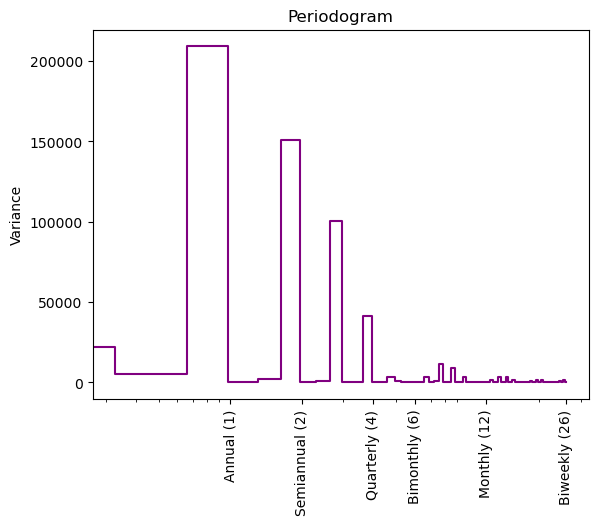

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


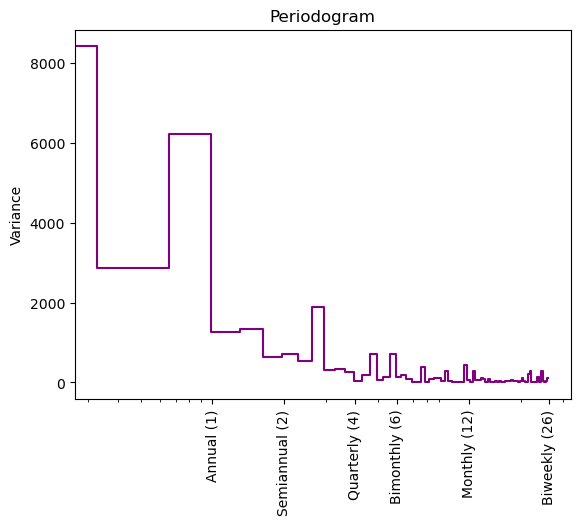

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


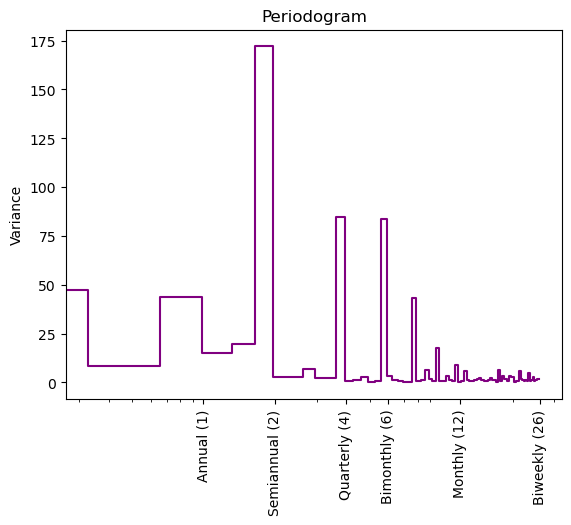

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


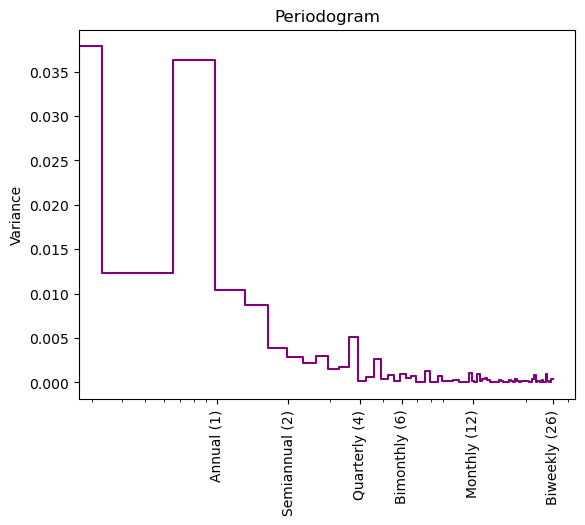

In [2]:
from functions.plot_periodogram import plot_periodogram
import matplotlib.pyplot as plt
import seaborn as sns

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [4]:
%%time

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

train_full['Seasonality'] = 0
test['Seasonality'] = 0

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    test_index = test[test['Location'] == location].index
    # Create time series
    series = pd.Series(train_full.loc[train_full_index, 'emission'].values, \
                   index=train_full.loc[train_full_index, 'date'])
    series.index = series.index.to_period('W')    
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 4
    elif location in groups_dictionary['Special 2']:
        pairs = 3
    elif location in groups_dictionary['High']:
        pairs = 6
    elif location in groups_dictionary['Low']:
        pairs = 4
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    # Calculate Seasonality
    y_pred = pd.Series(lr.predict(X), index=train_full_index)
    train_full.loc[train_full_index, 'Seasonality'] += y_pred

    # Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality'] += y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 55.4 s
Wall time: 16.2 s


Group: Special 1


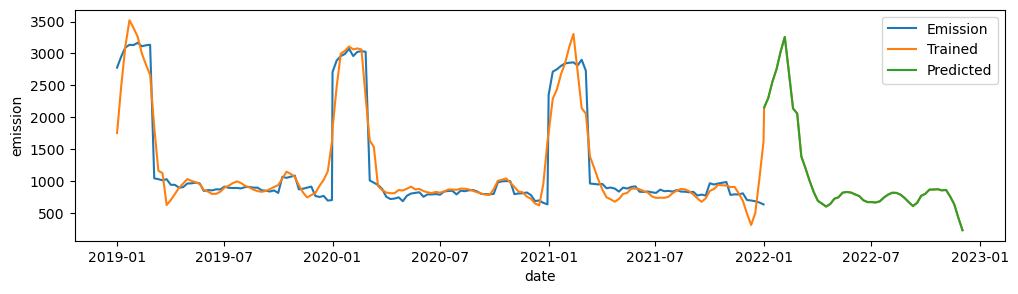

Group: Special 2


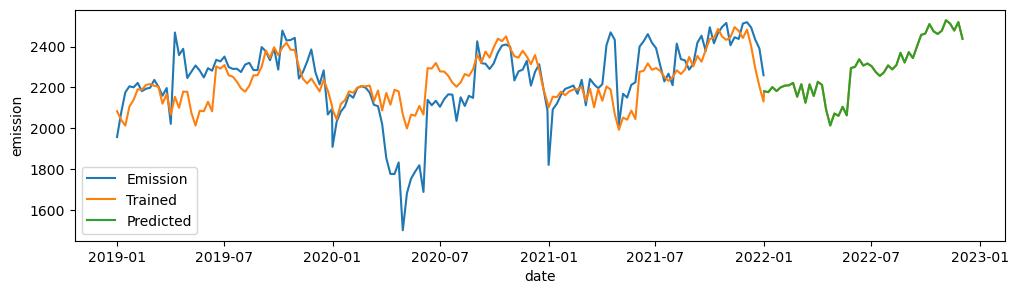

Group: High


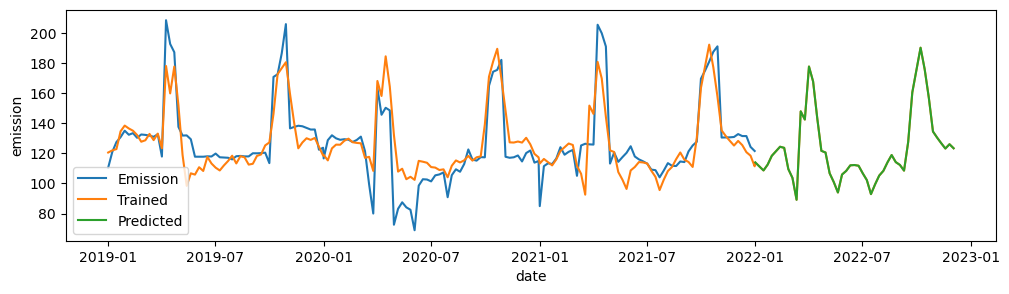

Group: Low


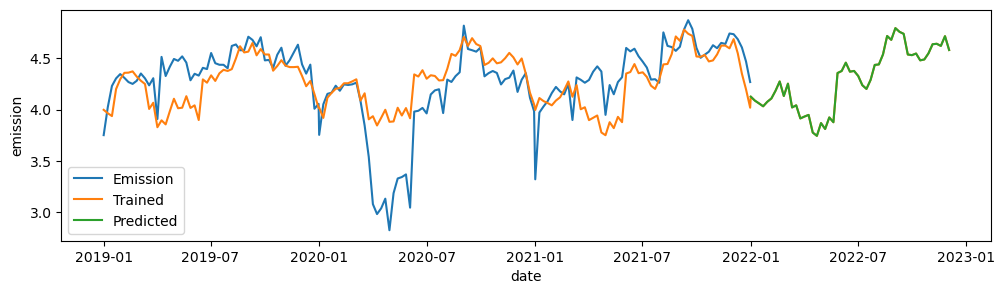

CPU times: total: 672 ms
Wall time: 1.09 s


In [5]:
%%time

train_and_test = pd.concat([train_full, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train_full[train_full['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_test[train_and_test['Location'] == location],
                 x='date', y='Seasonality', label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                 y='Seasonality', label='Predicted')
    plt.show()
    

## Division on the train and cv sets

First, let's find the average peak of low emissions for our 4 groups of locations:

In [6]:
%%time

train_full['residue'] = train_full['emission'] - train_full['Seasonality']

print('Dates with lowest emissions:')
for group in groups:
    print('Group: {}'.format(group))
    data = train_full.loc[train_full['Location_group'] == group, :].\
                            groupby('date')['residue'].median()
    print('Dates: {}'.format(data[data < data.quantile(0.03)]))

Dates with lowest emissions:
Group: Special 1
Dates: date
2019-03-05   -798.581977
2019-12-31   -913.387416
2020-03-04   -626.242282
2020-12-30   -980.982998
2021-12-31   -986.590204
Name: residue, dtype: float64
Group: Special 2
Dates: date
2020-04-08   -338.426515
2020-04-15   -411.373112
2020-04-22   -346.417936
2020-04-29   -565.323327
2020-06-03   -378.095247
Name: residue, dtype: float64
Group: High
Dates: date
2020-04-15   -34.151383
2020-04-29   -69.302388
2020-11-04   -36.370578
2021-03-26   -42.816627
2021-04-02   -38.354537
Name: residue, dtype: float64
Group: Low
Dates: date
2020-04-15   -4.703091
2020-04-22   -4.970381
2020-04-29   -5.988867
2020-05-06   -4.073748
2020-06-03   -4.645538
Name: residue, dtype: float64
CPU times: total: 15.6 ms
Wall time: 37 ms


It looks like the lowest emissions were at the week of 2020-04-29.

In [7]:
%%time

## Data after the initial COVID drop

post_drop = train_full.loc[train_full['date'] >= pd.to_datetime('2020-04-29'), :].copy(deep=True)

# Amount of weeks before drop
before_drop_weeks = len(train_full.loc[train_full['date'] < pd.to_datetime('2020-04-29'), 'WeekCount'].unique())



CPU times: total: 15.6 ms
Wall time: 10.7 ms


Now we'll divide this post-drop data on training and cross-validation sets:

In [8]:
%%time

# Calculate the proportion of test set weeks compared to the total number of weeks
proportion = len(test) / (len(post_drop) + len(test))

# Calculate the desired amount of weeks in the cross-validation set
post_drop_weeks = len(post_drop['WeekCount'].unique())
cv_weeks = round(post_drop_weeks * proportion)
train_weeks = post_drop_weeks - cv_weeks

assert(post_drop_weeks == cv_weeks + train_weeks)

print('Weeks in the training set: {}'.format(train_weeks))
print('Weeks in the cross-validation set: {}'.format(cv_weeks))

# Create training and cross-validation sets
train = pd.DataFrame(post_drop.loc[post_drop['WeekCount'] < train_weeks + before_drop_weeks, :])
cv = pd.DataFrame(post_drop.loc[post_drop['WeekCount'] >= train_weeks + before_drop_weeks, :])

print("The last 5 rows of the cross-validation set:")

Weeks in the training set: 57
Weeks in the cross-validation set: 32
The last 5 rows of the cross-validation set:
CPU times: total: 0 ns
Wall time: 5.98 ms


## 00. Seasonality

Now we'll remove seasonality based only on post-drop data (except for the Special 1 seasonality, for which we'll need all weeks):

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


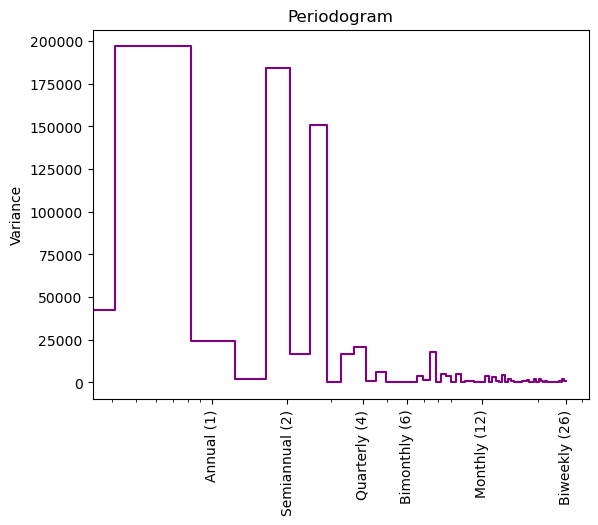

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


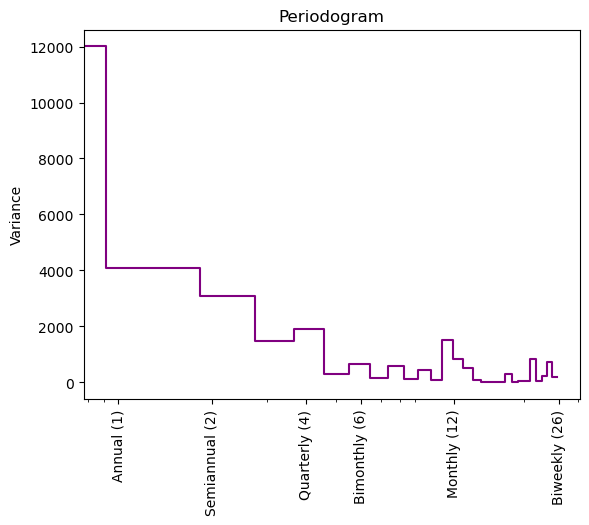

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


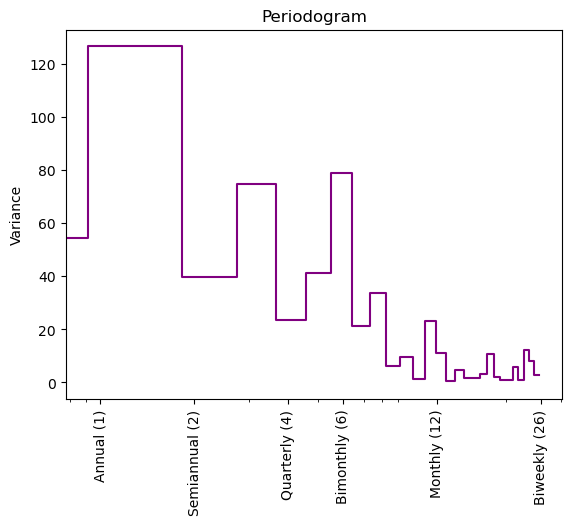

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


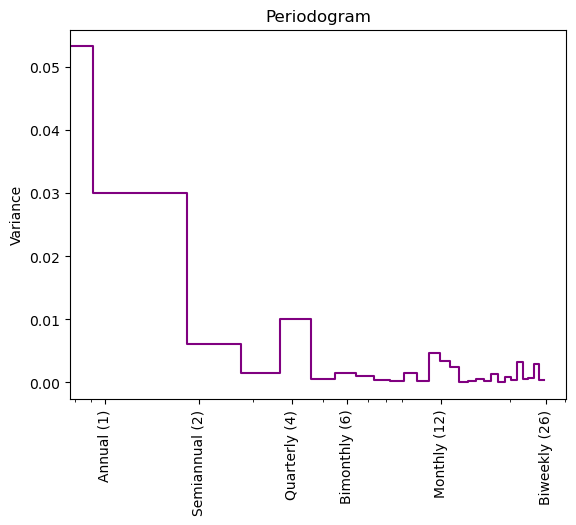

In [9]:
study_number = '00'


# All data except for cv (for Special 1 group)
cv_start_date = cv['date'].min()
pre_cv = train_full[train_full['date'] < cv_start_date].copy(deep=True)

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    
    
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(pre_cv.loc[pre_cv['Location'] == location, 'emission'].values, \
                   index=pre_cv.loc[pre_cv['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 

    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [10]:
%%time

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    pre_cv_index = pre_cv[pre_cv['Location'] == location].index
    train_index = train[train['Location'] == location].index
    cv_index = cv[cv['Location'] == location].index
    
    
    
    # Create time series
    if location in groups_dictionary['Special 1']:
        series = pd.Series(pre_cv.loc[pre_cv_index, 'emission'].values, 
                   index=pre_cv.loc[pre_cv_index, 'date'])
    else:
        series = pd.Series(train.loc[train_index, 'emission'].values,
                           index=train.loc[train_index, 'date'])
   
 
    series.index = series.index.to_period('W')   
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 3
    elif location in groups_dictionary['Special 2']:
        pairs = 5
    elif location in groups_dictionary['High']:
        pairs = 13
    elif location in groups_dictionary['Low']:
        pairs = 5
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=pre_cv_index)
        pre_cv.loc[pre_cv_index, 'Seasonality_train'] = y_pred
        train.loc[train_index, 'Seasonality_train'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality_train'] = y_pred
    
    # Continue trend on the cv set:
   
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    cv.loc[cv_index, 'Seasonality_train'] = y_pred

    locations_count +=1
    #print(locations_count)


CPU times: total: 38 s
Wall time: 11.2 s


Group: Special 1


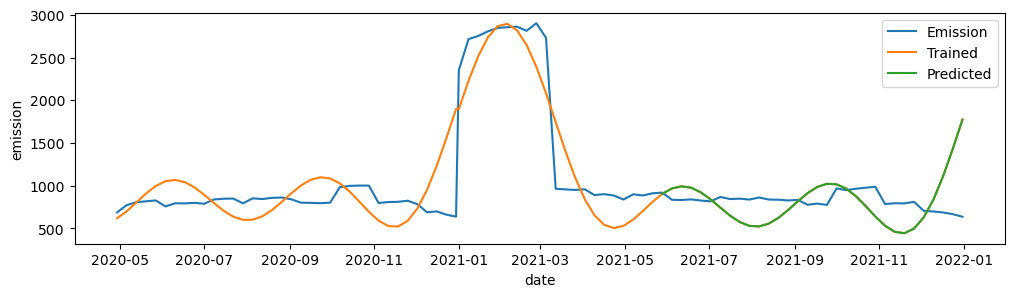

Group: Special 2


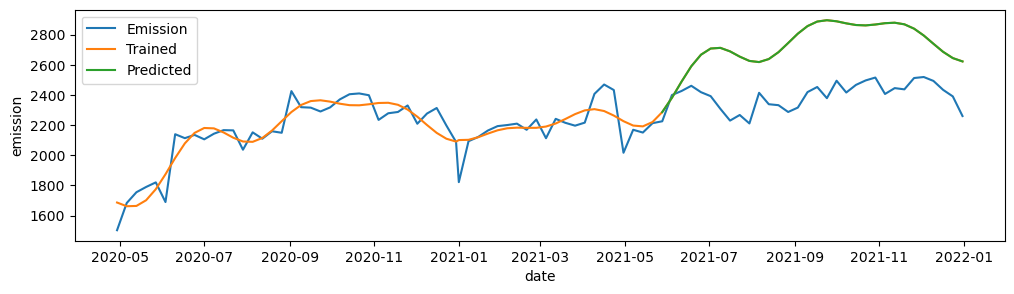

Group: High


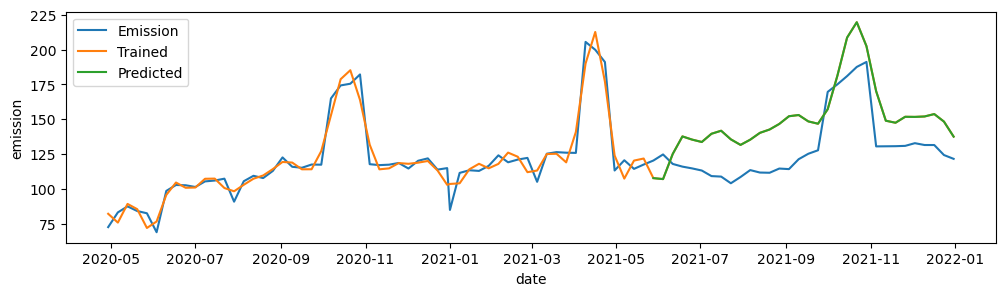

Group: Low


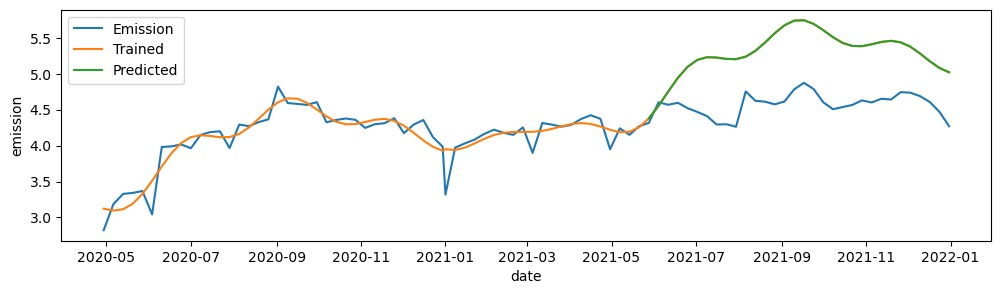

CPU times: total: 750 ms
Wall time: 1.08 s


In [11]:
%%time

train_and_cv = pd.concat([train, cv])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='Seasonality_train', label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='date', 
                y='Seasonality_train', label='Predicted')
    plt.show()
    

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


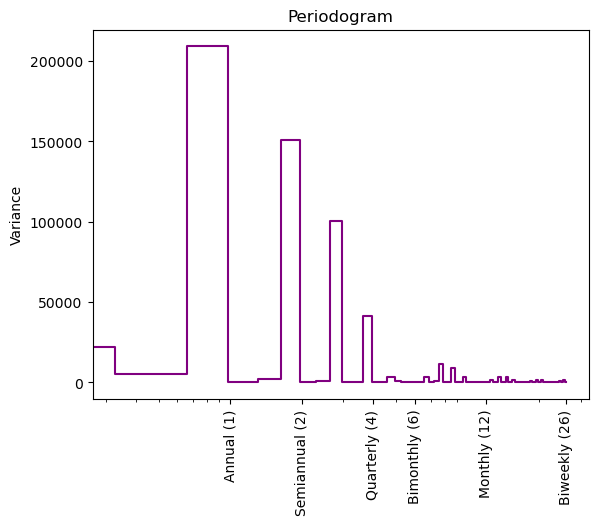

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


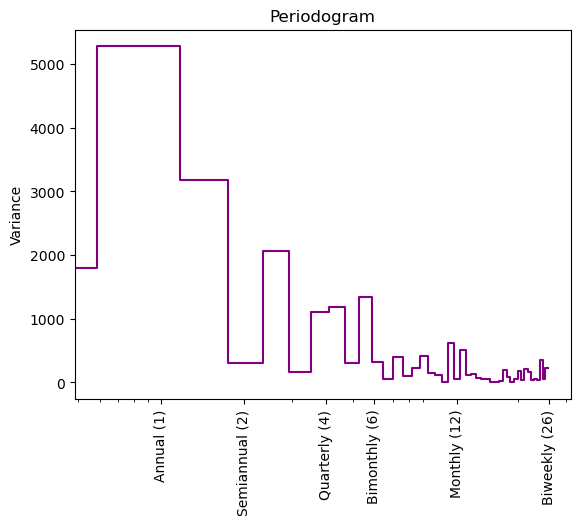

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


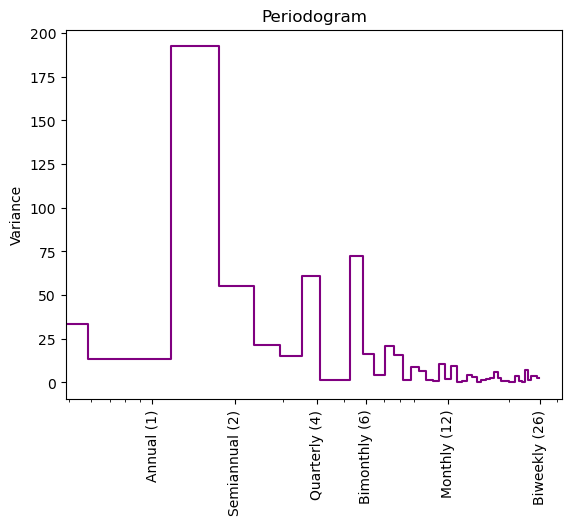

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


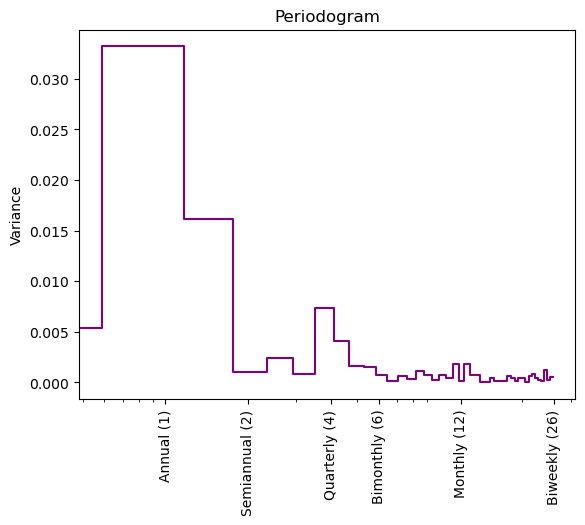

In [12]:
for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
     
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(post_drop.loc[post_drop['Location'] == location, 'emission'].values, \
                   index=post_drop.loc[post_drop['Location'] == location, 'date']) 

    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [13]:
%%time

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    post_drop_index = post_drop[post_drop['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    # Create time series
    if location in groups_dictionary['Special 1']:
        series = pd.Series(train_full.loc[train_full_index, 'emission'].values, 
                   index=train_full.loc[train_full_index, 'date'])
    else:
        series = pd.Series(post_drop.loc[post_drop_index, 'emission'].values,
                           index=post_drop.loc[post_drop_index, 'date'])
 
    series.index = series.index.to_period('W')   
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 4
    elif location in groups_dictionary['Special 2']:
        pairs = 6
    elif location in groups_dictionary['High']:
        pairs = 9
    elif location in groups_dictionary['Low']:
        pairs = 6
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Seasonality'] = y_pred
        post_drop.loc[post_drop_index, 'Seasonality'] = y_pred[post_drop_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=post_drop_index)
        post_drop.loc[post_drop_index, 'Seasonality'] = y_pred
    
    # Continue trend on the cv set:
    
   
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality'] = y_pred

    locations_count +=1
    #print(locations_count)


CPU times: total: 42.2 s
Wall time: 12.4 s


Group: Special 1


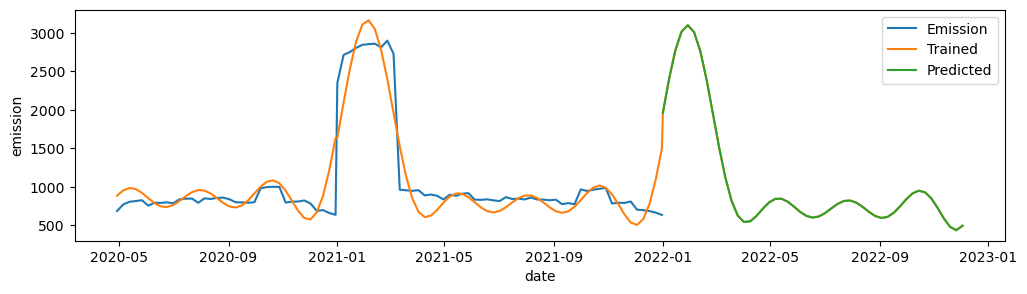

Group: Special 2


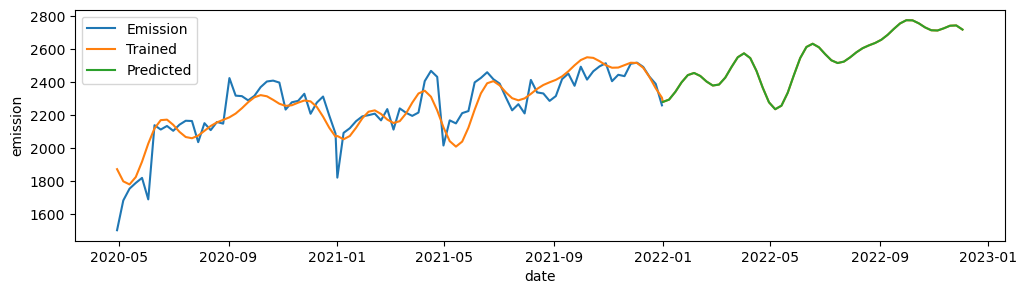

Group: High


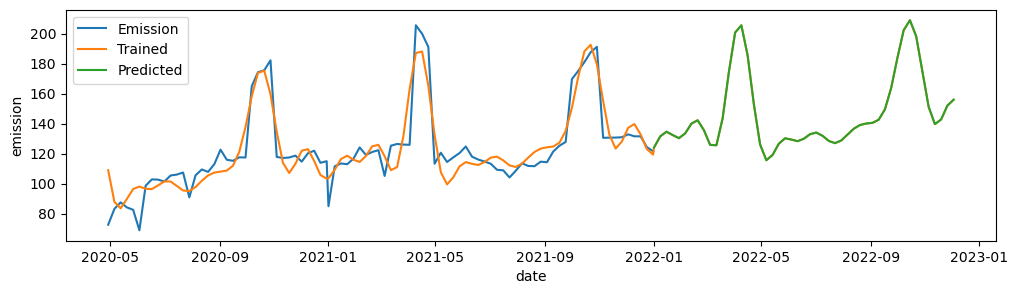

Group: Low


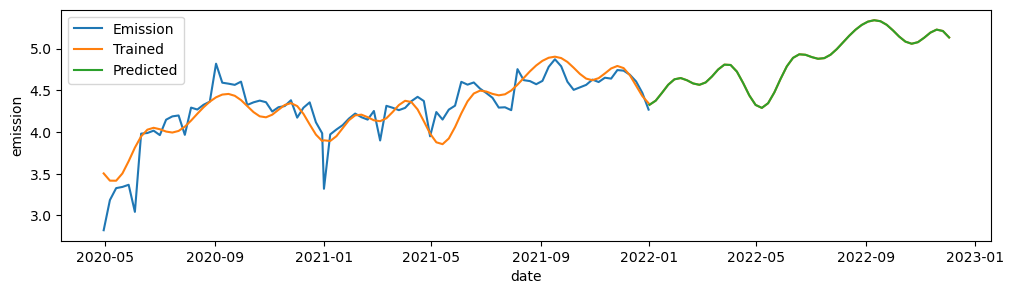

CPU times: total: 1.22 s
Wall time: 1.04 s


In [14]:
%%time

post_drop_and_test = pd.concat([post_drop, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = post_drop[post_drop['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = post_drop_and_test[post_drop_and_test['Location'] == location],
                 x='date', y='Seasonality', label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                y='Seasonality', label='Predicted')
    plt.show()
    

In [15]:
%%time

from sklearn.metrics import mean_squared_error

scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

scores_df.loc[int(study_number), 'Comment'] = 'Seasonality'

# Calculate train and cv RMSEs
score_train = mean_squared_error(train['emission'], train['Seasonality_train'], squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
score_cv = mean_squared_error(cv['emission'], cv['Seasonality_train'], squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv


# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['Seasonality']})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

CPU times: total: 31.2 ms
Wall time: 51.8 ms


In [16]:
scores_df.loc[int(study_number), 'Test RMSE'] = 29.79385
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Seasonality,17.410175,30.481573,29.79385


In [17]:
for data in [pre_cv, train, cv]:
    data['emission_4_' + study_number] = data['emission'] - data['Seasonality_train']
    data['emission_pred_4_' + study_number] = data['Seasonality_train']
    
for data in [train_full, post_drop]:
    data['emission_4_' + study_number] = data['emission'] - data['Seasonality']
    data['emission_pred_4_' + study_number] = data['Seasonality']
    
test['emission_pred_4_' + study_number] = test['Seasonality']
    
train.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,WeekCount,Seasonality,residue,Seasonality_train,emission_4_00,emission_pred_4_00
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,
ID_-0.510_29.290_2020_17,-0.51,29.29,2020,17,2.822296,Low,2020-04-29,-0.5129.29,70,3.881146,-1.058849,3.121524,-0.299228,3.121524
ID_-0.510_29.290_2020_18,-0.51,29.29,2020,18,3.184253,Low,2020-05-06,-0.5129.29,71,3.884739,-0.700486,3.096050,0.088203,3.096050
ID_-0.510_29.290_2020_19,-0.51,29.29,2020,19,3.327405,Low,2020-05-13,-0.5129.29,72,4.018529,-0.691124,3.113904,0.213500,3.113904
ID_-0.510_29.290_2020_20,-0.51,29.29,2020,20,3.341604,Low,2020-05-20,-0.5129.29,73,3.942680,-0.601076,3.190730,0.150874,3.190730
ID_-0.510_29.290_2020_21,-0.51,29.29,2020,21,3.367512,Low,2020-05-27,-0.5129.29,74,4.015351,-0.647839,3.327759,0.039753,3.327759


## 01. Seasonality_2

As in Part 2, we'll remove non-annual seasonalities:

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


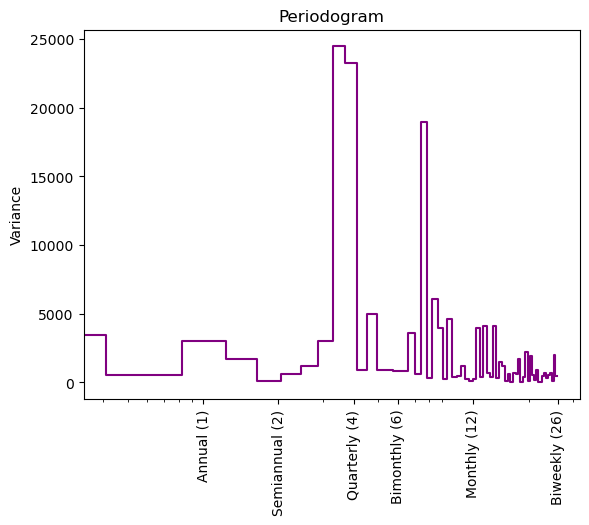

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


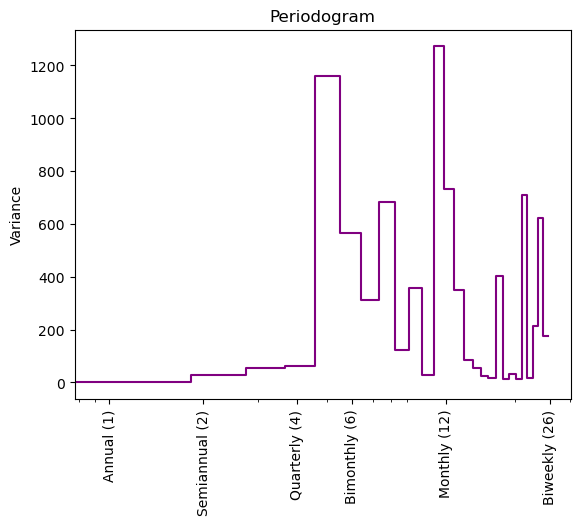

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


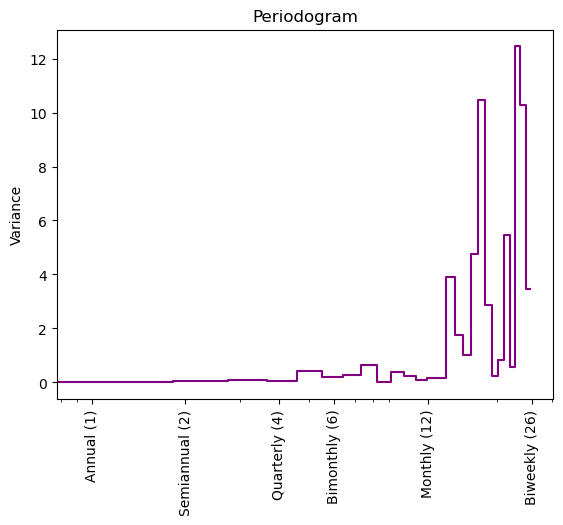

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


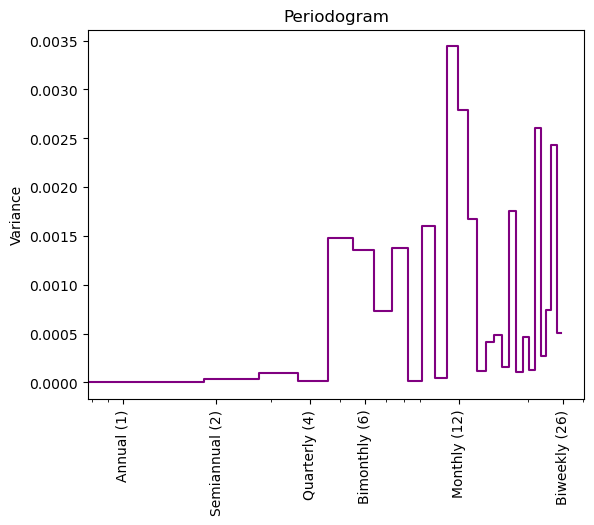

In [18]:
study_number = '01'

scores_df.loc[int(study_number), 'Comment'] = 'Seasonality_2'


for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    
    
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(pre_cv.loc[pre_cv['Location'] == location, 'emission_4_00'].values, \
                   index=pre_cv.loc[pre_cv['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission_4_00'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 

    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [19]:
%%time

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    pre_cv_index = pre_cv[pre_cv['Location'] == location].index
    train_index = train[train['Location'] == location].index
    cv_index = cv[cv['Location'] == location].index
    
    # Create time series
    if location in groups_dictionary['Special 1']:
        series = pd.Series(pre_cv.loc[pre_cv_index, 'emission_4_00'].values, 
                   index=pre_cv.loc[pre_cv_index, 'date'])
    else:
        series = pd.Series(train.loc[train_index, 'emission_4_00'].values,
                           index=train.loc[train_index, 'date'])
   
 
    series.index = series.index.to_period('W')   
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 3
        fourier = CalendarFourier(freq="Q", order=pairs)  
    elif location in groups_dictionary['Special 2']:
        pairs = 6
        fourier = CalendarFourier(freq="Q", order=pairs)  
    elif location in groups_dictionary['High']:
        pairs = 2
        fourier = CalendarFourier(freq="M", order=pairs)  
    elif location in groups_dictionary['Low']:
        pairs = 6
        fourier = CalendarFourier(freq="Q", order=pairs)  
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="Q", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=pre_cv_index)
        pre_cv.loc[pre_cv_index, 'Seasonality_2_train'] = y_pred
        train.loc[train_index, 'Seasonality_2_train'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality_2_train'] = y_pred
    
    # Continue trend on the cv set:
   
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    cv.loc[cv_index, 'Seasonality_2_train'] = y_pred

    locations_count +=1
    #print(locations_count)


CPU times: total: 35 s
Wall time: 11.5 s


Group: Special 1


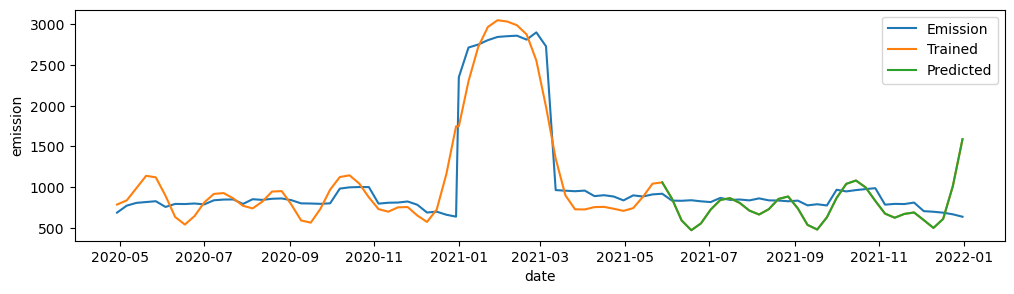

Group: Special 2


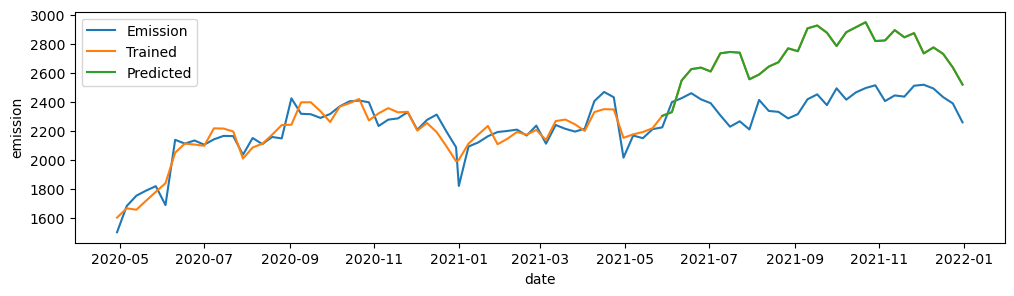

Group: High


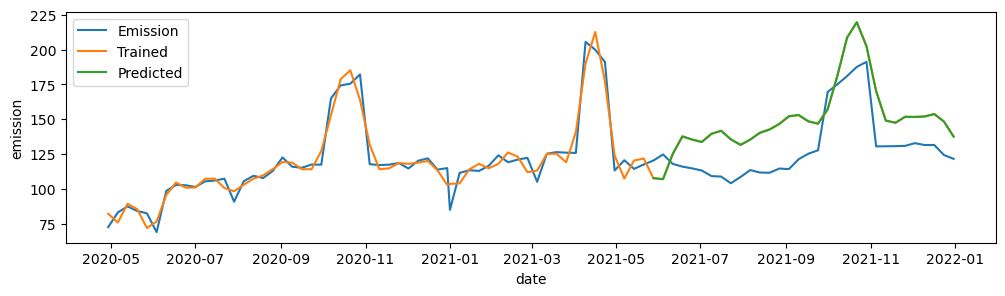

Group: Low


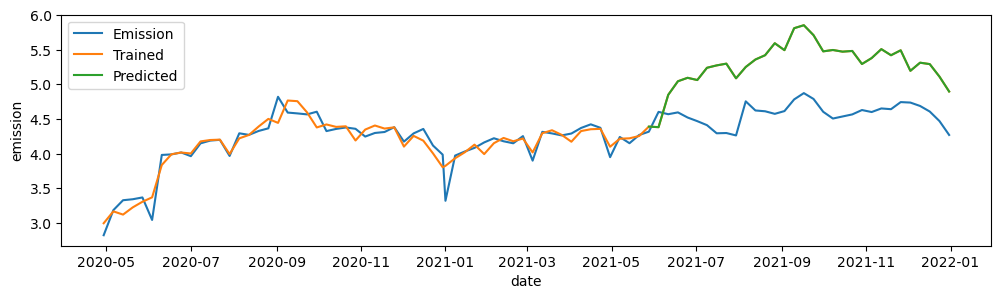

CPU times: total: 1.12 s
Wall time: 1.17 s


In [20]:
%%time

for data in [pre_cv, train, cv]:
    data['emission_4_' + study_number] = data['emission'] - data['Seasonality_train'] - data['Seasonality_2_train']
    data['emission_pred_4_' + study_number] = data['Seasonality_train'] + data['Seasonality_2_train']

train_and_cv = pd.concat([train, cv])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='emission_pred_4_' + study_number, label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='date', 
                y='emission_pred_4_' + study_number, label='Predicted')
    plt.show()
    

In [21]:
# Calculate train and cv RMSEs
score_train = mean_squared_error(train['emission'], train['emission_pred_4_' + study_number], squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
score_cv = mean_squared_error(cv['emission'], cv['emission_pred_4_' + study_number], squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Seasonality,17.410175,30.481573,29.79385
1,Seasonality_2,14.135618,28.859140,NaN


Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


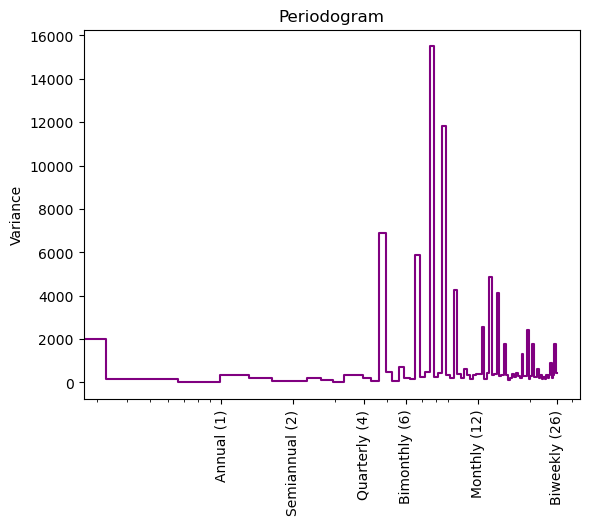

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


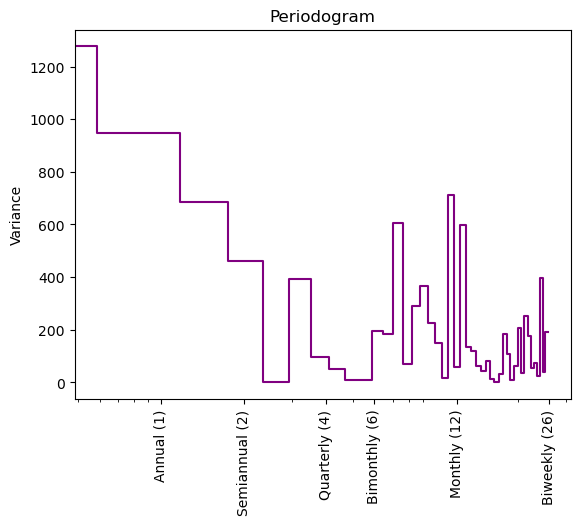

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


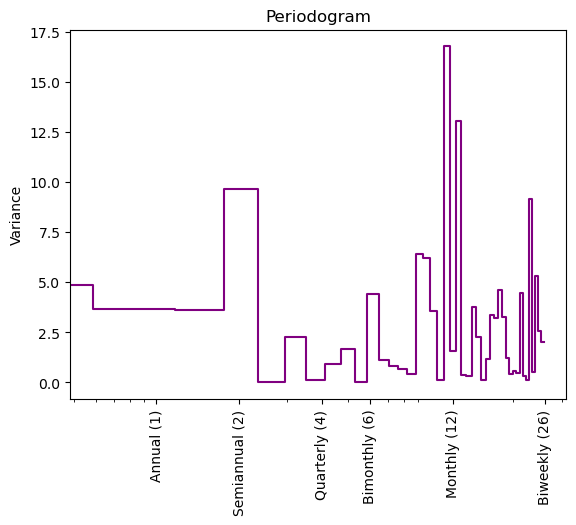

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


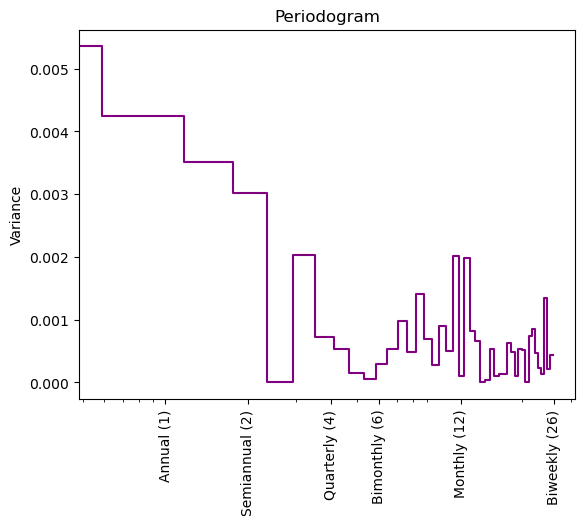

In [22]:
for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
     
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission_4_00'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(post_drop.loc[post_drop['Location'] == location, 'emission_4_00'].values, \
                   index=post_drop.loc[post_drop['Location'] == location, 'date']) 

    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [ ]:
%%time

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    post_drop_index = post_drop[post_drop['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    # Create time series
    if location in groups_dictionary['Special 1']:
        series = pd.Series(train_full.loc[train_full_index, 'emission_4_00'].values, 
                   index=train_full.loc[train_full_index, 'date'])
    else:
        series = pd.Series(post_drop.loc[post_drop_index, 'emission_4_00'].values,
                           index=post_drop.loc[post_drop_index, 'date'])
 
    series.index = series.index.to_period('W')   
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 3
        fourier = CalendarFourier(freq="Q", order=pairs)  
    elif location in groups_dictionary['Special 2']:
        pairs = 4
        fourier = CalendarFourier(freq="A", order=pairs)  
    elif location in groups_dictionary['High']:
        pairs = 2
        fourier = CalendarFourier(freq="A", order=pairs)  
    elif location in groups_dictionary['Low']:
        pairs = 2
        fourier = CalendarFourier(freq="A", order=pairs)  
    else:
        raise ValueError('A location does not belong to any group.')
        
    
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Seasonality_2'] = y_pred
        post_drop.loc[post_drop_index, 'Seasonality_2'] = y_pred[post_drop_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=post_drop_index)
        post_drop.loc[post_drop_index, 'Seasonality_2'] = y_pred
    
    # Continue trend on the cv set:
    
   
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality_2'] = y_pred

    locations_count +=1
    #print(locations_count)


In [ ]:
%%time

for data in [train_full, post_drop]:
    data['emission_4_' + study_number] = data['emission'] - data['Seasonality'] - data['Seasonality_2']
    data['emission_pred_4_' + study_number] = data['Seasonality'] + data['Seasonality_2']
    
test['emission_pred_4_' + study_number] = test['Seasonality'] + test['Seasonality_2']

post_drop_and_test = pd.concat([post_drop, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = post_drop[post_drop['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = post_drop_and_test[post_drop_and_test['Location'] == location],
                 x='date', y='emission_pred_4_' + study_number, label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                y='emission_pred_4_' + study_number, label='Predicted')
    plt.show()
    

In [ ]:

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['emission_pred_4_' + study_number]})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

In [ ]:
scores_df.loc[int(study_number), 'Test RMSE'] = 29.79705
scores_df

In [ ]:
for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = post_drop[post_drop['Location'] == location],
                 x='date', y='emission_4_' + study_number, label='Residue')
    plt.show()

## 02. Seasonality_3

In [ ]:
study_number = '02'

scores_df.loc[int(study_number), 'Comment'] = 'Seasonality_3'


for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    
    
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(pre_cv.loc[pre_cv['Location'] == location, 'emission_4_01'].values, \
                   index=pre_cv.loc[pre_cv['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission_4_01'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 

    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [ ]:
%%time

locations_count=0

for location in train_full['Location'].unique():
    # Save indices
    pre_cv_index = pre_cv[pre_cv['Location'] == location].index
    train_index = train[train['Location'] == location].index
    cv_index = cv[cv['Location'] == location].index
    
    # Create time series
    if location in groups_dictionary['Special 1']:
        series = pd.Series(pre_cv.loc[pre_cv_index, 'emission_4_01'].values, 
                   index=pre_cv.loc[pre_cv_index, 'date'])
    else:
        series = pd.Series(train.loc[train_index, 'emission_4_01'].values,
                           index=train.loc[train_index, 'date'])
   
 
    series.index = series.index.to_period('W')   
    
    ## sin/cos pairs for annual seasonality 
    if location in groups_dictionary['Special 1']:
        pairs = 2
    elif location in groups_dictionary['Special 2']:
        pairs = 2
    elif location in groups_dictionary['High']:
        pairs = 2
    elif location in groups_dictionary['Low']:
        pairs = 2
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="M", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=pre_cv_index)
        pre_cv.loc[pre_cv_index, 'Seasonality_3_train'] = y_pred
        train.loc[train_index, 'Seasonality_3_train'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality_3_train'] = y_pred
    
    # Continue trend on the cv set:
   
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    cv.loc[cv_index, 'Seasonality_3_train'] = y_pred

    locations_count +=1
    #print(locations_count)


In [ ]:
%%time

for data in [pre_cv, train, cv]:
    data['emission_4_' + study_number] = data['emission'] - data['Seasonality_train'] - data['Seasonality_2_train'] -\
            data['Seasonality_3_train']
    data['emission_pred_4_' + study_number] = data['Seasonality_train'] + data['Seasonality_2_train'] +\
            data['Seasonality_3_train']

train_and_cv = pd.concat([train, cv])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_cv[train_and_cv['Location'] == location],
                 x='date', y='emission_pred_4_' + study_number, label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='date', 
                y='emission_pred_4_' + study_number, label='Predicted')
    plt.show()
    

In [ ]:
# Calculate train and cv RMSEs
score_train = mean_squared_error(train['emission'], train['emission_pred_4_' + study_number], squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
score_cv = mean_squared_error(cv['emission'], cv['emission_pred_4_' + study_number], squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

scores_df

The Cross-val score went up, so we won't use Seasonality_3.

## 03. Trend

In [ ]:
%%time

study_number = '03'

locations_count=0

for location in train['Location'].unique():
    
    #Save indices
    post_drop_index = post_drop[post_drop['Location'] == location].index
    train_index = train[train['Location'] == location].index
    cv_index = cv[cv['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    
    ## Calculate trend on the training set
    series = pd.Series(train.loc[train_index, 'emission_4_01'].values, \
                   index=train.loc[train_index, 'date'])
        
    series.index = series.index.to_period('W')    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=2, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)

    y_pred = pd.Series(lr.predict(X), index=train_index)
    train.loc[train_index, 'Trend_train'] = y_pred
    
    ## Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    cv.loc[cv_index, 'Trend_train'] = y_pred
    
    
    ## Calculate trend on the post_drop set
    series = pd.Series(post_drop.loc[post_drop_index, 'emission_4_01'].values, \
                   index=post_drop.loc[post_drop_index, 'date'])
        
    series.index = series.index.to_period('W')    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=2, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)

    y_pred = pd.Series(lr.predict(X), index=post_drop_index)
    post_drop.loc[post_drop_index, 'Trend'] = y_pred
    
    ## Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Trend'] = y_pred

    locations_count +=1
    # print(locations_count)



In [ ]:
%%time

train_and_cv = pd.concat([train, cv])

for i, representative in four_representatives.iterrows():
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = post_drop[post_drop["Location"] == representative['Location']], x='date', y='emission_4_01',
                 label='Residue').\
            set(title='Representative of Group {}, for cross-validation'.format(representative["Group"]))
    sns.lineplot(data = train_and_cv[train_and_cv["Location"] == representative['Location']], x='date', y='Trend_train',
                label='Trend Trained')
    sns.lineplot(data = cv[cv["Location"] == representative['Location']], x='date', y='Trend_train',
                label='Trend Predicted')
    plt.show()

In [ ]:
%%time

post_drop_and_test = pd.concat([post_drop, test])

for i, representative in four_representatives.iterrows():
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = post_drop[post_drop["Location"] == representative['Location']], x='date', y='emission_4_01',
                 label='Residue').\
            set(title='Representative of Group {}, for testing'.format(representative["Group"]))
    sns.lineplot(data = post_drop_and_test[post_drop_and_test["Location"] == representative['Location']],
                 x='date', y='Trend',
                label='Trend Trained')
    sns.lineplot(data = test[test["Location"] == representative['Location']], x='date', y='Trend',
                label='Trend Predicted')
    plt.show()